<a href="https://colab.research.google.com/github/isegura/OCW-UC3M-NLPDeep-2023/blob/main/tema4_5_cnn_we_multi_exist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png" width=50%/>

<h1><font color='#12007a'>Procesamiento de Lenguaje Natural con Aprendizaje Profundo</font></h1>
<p>Autora: Isabel Segura Bedmar</p>

<img align='right' src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>      

# 4.5: Inicializando un modelo CNN con word embeddings para la multi-clasificación de mensajes sexistas.

En un ejercicio anterior, ya aplicamos un modelo CNN a la multi-clasificación  de mensajes sexistas en el dataset EXIST 202 (http://nlp.uned.es/exist2021/). Dicho modelo obtenía una macro F1 bastante baja (37%).

Vamos a ver si el uso de un modelo de word embeddings para inicializar los pesos del modelo CNN proporciona alguna mejora respecto a la inicialización aleatoria. Usaremos la misma arquitectura, excepto el tipo de inicialización.

**NOTA PARA PODER EJECUTAR ESTE NOTEBOOK**:

1) Para poder ejercutar correctamente este notebook, deberás abrirlo en tu Google Drive (por ejemplo, en la carpeta 'Colab Notebooks').

2) Además, debes guardar el dataset en tu Google Drive, dentro de carpeta 'Colab Notebooks/data/exist2021/'.



## Cargar el dataset

Lo primero que debes hacer es cargar el dataset. Como hemos comentado antes, recuerda que para que puedas ejecutar este notebook, deberás haber descargado los ficheros del dataset y haberlos almacenados en tu carpeta 'Colab Notebooks/data/exist2021/' dentro de tu Gooogle Drive.



In [1]:
from google.colab import drive
# monta tu unidad de google drive
drive.mount('/content/drive')

# cambiamos el directorio de trabajo a la carpeta donde está almacenado el dataset
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/exist2021/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos los conjuntos de datos de training y evaluación en dos objetos dataframes de pandas:

In [2]:
import pandas as pd

df_train = pd.read_csv("train.tsv",  sep='\t')
df_test = pd.read_csv("test.tsv",  sep='\t')

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

# mostramos los primeros registros del training:
df_train.head()

tamaño training: (6977, 7)
tamaño test: (4368, 7)


,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


El dataset es multilingüe, vamos a quedarnos únicamente con los textos en inglés:

In [3]:
df_train=df_train[df_train['language']=='en']
df_test=df_test[df_test['language']=='en']
print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)


tamaño training: (3436, 7)
tamaño test: (2208, 7)


En esta tarea, nuestro objetivo es clasificar los mensajes sexistas en las cinco categorías anteriormente definidas. Los mensajes no sexistas no van a ser clasificados y por ese motivo, vamos a eliminarlos, o visto de otra forma, únicamente conservaremos los mensajes clasificados como sexistas en la tarea 1 (task1):

In [4]:
df_train = df_train[df_train['task1'] == 'sexist']
df_test = df_test[df_test['task1'] == 'sexist']

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

df_train.head()

tamaño training: (1636, 7)
tamaño test: (1158, 7)


,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
5,EXIST2021,6,twitter,en,@Smithcouple971 Hello....m raj....m with good ...,sexist,sexual-violence
10,EXIST2021,11,twitter,en,@hapyshoper79 @Dis_Critic @MairiJCam @cazadams...,sexist,ideological-inequality
15,EXIST2021,16,twitter,en,@Ponderer_O_Purg @BynameRose @GameOverRos @nat...,sexist,ideological-inequality


En este ejercicio, sólo vamos a usar **text** y **task2**:


In [5]:
df_train = df_train.drop(['test_case', 'id', 'source', 'task1'], axis=1)
df_test = df_test.drop(['test_case', 'id', 'source', 'task1'], axis=1)
# renombramos task1 a label
df_train = df_train.rename(columns={'task2':'label'})
df_test = df_test.rename(columns={'task2':'label'})
# mostramos los primeros registros del training
df_train.head()

,language,text,label
0,en,"She calls herself ""anti-feminazi"" how about sh...",ideological-inequality
2,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",objectification
5,en,@Smithcouple971 Hello....m raj....m with good ...,sexual-violence
10,en,@hapyshoper79 @Dis_Critic @MairiJCam @cazadams...,ideological-inequality
15,en,@Ponderer_O_Purg @BynameRose @GameOverRos @nat...,ideological-inequality


Ya vimos en el ejercicio anterior, que la distribución de las clases es similar en los dos conjuntos: training y test.
Respecto a las clases, la más frecuente es 'ideological inequality', y la menos 'objetification'. Es de esperar que el modelo proporcione resultados más bajos para las clases menos frecuentes.

## Label encoding

Esta tarea consiste en transformar las labels de formato a texto a un formato numérico.

En el caso de multi-clasifición, cada clase se va a representar con un vector one-hot.


In [30]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = df_train['label'].tolist()
# print(NUM_LABELS)


y_test = df_test['label'].tolist()

le = LabelEncoder()

print("antes de transform: ", y_train[:10])
y_train = le.fit_transform(y_train)
print("labels:", le.classes_)
LABELS = le.classes_
NUM_LABELS = len(LABELS)

print("después de transform:", y_train[:10])
y_train_cat = to_categorical(y_train)
print("después de transform:", y_train_cat[:10])

y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)


{'stereotyping-dominance', 'misogyny-non-sexual-violence', 'sexual-violence', 'objectification', 'ideological-inequality'}
antes de transform:  ['ideological-inequality', 'objectification', 'sexual-violence', 'ideological-inequality', 'ideological-inequality', 'stereotyping-dominance', 'ideological-inequality', 'sexual-violence', 'ideological-inequality', 'sexual-violence']
labels: ['ideological-inequality' 'misogyny-non-sexual-violence' 'objectification'
 'sexual-violence' 'stereotyping-dominance']
después de transform: [0 2 3 0 0 4 0 3 0 3]
después de transform: [[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


## Representación de los textos

Para que los textos puedan ser interpretados por el modelo CNN, necesitan también ser representado en un formato que pueda entender dicho modelo.
Vamos a aplicar los mismo pasos que se utilizaron en el ejercicio 2.1.


In [7]:
from keras.preprocessing.text import Tokenizer

X_train = df_train['text'].tolist()

tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))

Tamaño del vocabulario =9427


In [13]:
from keras.utils import pad_sequences
MAX_LEN=45
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')


## Cargar el modelo de word embeddings
El siguiente paso será cargar el modelo pre-entrenado de word embeddings. En este ejercicio, vamos a utilizar el modelo **glove-wiki-gigaword-50**, que es relativamente pequeño (y nos permitirá ejecutar este notebook en un tiempo corto). Para cargarlo usaremos la librería Gensim.

Puedes probar con otros modelos de word embeddings (https://github.com/RaRe-Technologies/gensim-data).

In [8]:
import gensim.downloader as api
model_we = api.load("glove-wiki-gigaword-50")


[==================================================] 100.0% 66.0/66.0MB downloaded


Obtenemos la dimensión de los embeddings:

In [9]:
wv = model_we['house']
print(wv.shape)
EMBED_SIZE=wv.shape[0]
print(EMBED_SIZE)


(50,)
50


## Crear matriz de embeddings
Una vez cargado el modelo, continuamos creando una matriz de tamaño |V| x d, donde |V| ya hemos visto que es igual a 16645, y d es 50 (la dimensión de los vectores en el modelo glove-wiki-gigaword-50). La matriz la inicializamos a 0.

In [14]:
import numpy as np
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_we[word]
        # word embedding para la palabra con índice i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

print('matriz creada')

embedding_matrix

matriz creada


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.17050001e-01,  4.65149999e-01, -4.67570007e-01, ...,
        -4.37819995e-02,  4.10129994e-01,  1.79600000e-01],
       ...,
       [-1.87619999e-01, -5.59580028e-01, -1.22950003e-01, ...,
         3.03319991e-01, -6.16909981e-01,  4.10899997e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.09389997e-01, -8.13610017e-01, -2.60380004e-02, ...,
         8.20909976e-04, -8.71699989e-01, -3.34560007e-01]])

## CNN

Una vez que ya hemos procesado el texto, podemos definir el modelo.



In [11]:
import tensorflow as tf
# asegurar que los experimentos se pueden reproducir
tf.random.set_seed(42)
tf.__version__

'2.13.0'

### Crear el modelo
En este ejercicio, vamos a emplear la misma arquitectura CNN que ya usamos para resolver la multi-clasificación de mensajes sexistas.
La única diferencia está en la capa Embedding, donde vamos a pasar al argumento **weights** la matriz que acabamos de crear:

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

model = Sequential()
EMBEDDING_SIZE=50 #probar con 200, 300

### Esta es la única capa que se ve modificada
model.add(Embedding(NUM_WORDS, EMBED_SIZE,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix]))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

A continuación, ya podemos añadir otras capas como una capa Densa (suelen mejorar los resultados de clasificación).
La última capa usa la función **softmax** con cinco neuronas, una por cada clase, y va a devolver una probabilidad por cada una de ellas.
El modelo va a proponer la clase con mayor probabilidad.

Además, debemos indicar el optimizador y la función de coste, que al ser un problema de multi-clasificación debe ser **categorical_crossentropy**:

In [21]:

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 45, 50)            471350    
                                                                 
 conv1d_6 (Conv1D)           (None, 45, 128)           25728     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 22, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 22, 64)            24640     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 11, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 11, 32)           

### Entrenar el modelo



In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Para el entrenamiento después de 3 epochs sin el error en el conjunto de validación no mejora
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


In [23]:
epochs = 10
batch_size = 16

# training
history=model.fit(encoded_train_pad,  # textos preprocesados
                  y_train_cat,          # labels en formato one-hot
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )


Epoch 1/10
82/82 [==============================] - 2s 12ms/step - loss: 1.5657 - accuracy: 0.2943 - val_loss: 1.5506 - val_accuracy: 0.3628
Epoch 2/10
82/82 [==============================] - 1s 11ms/step - loss: 1.3815 - accuracy: 0.4358 - val_loss: 1.3762 - val_accuracy: 0.4482
Epoch 3/10
82/82 [==============================] - 1s 11ms/step - loss: 1.1471 - accuracy: 0.5352 - val_loss: 1.3933 - val_accuracy: 0.4238
Epoch 4/10
82/82 [==============================] - 1s 10ms/step - loss: 0.8574 - accuracy: 0.6789 - val_loss: 1.4159 - val_accuracy: 0.4390
Epoch 5/10
82/82 [==============================] - 1s 8ms/step - loss: 0.5619 - accuracy: 0.8050 - val_loss: 1.4290 - val_accuracy: 0.4878


El entrenamiento se detiene en la epoch 5.

### Curvas de aprendizaje

Estos gráficos nos permiten ver cómo el modelo aprende a lo largo de su entrenamiento, en concreto, muestran sus resultados al ser evaluados en cada epoch sobre su conjunto de entrenamiento y el conjunto de validación. Se pueden mostrar gráficos distintos para el acuracy y para el error (su comportamiento será opuesto).

Estas curvas se utilizan para diagnosticar un modelo que no es capaz de resolver la tarea, que sufre de sobre-aprendizaje (se ajusta perfecgtamente al conjunto de entrenamiento, pero no es capaz de resolver el problema en el conjunto de validación), o si el modelo está bien ajustado.




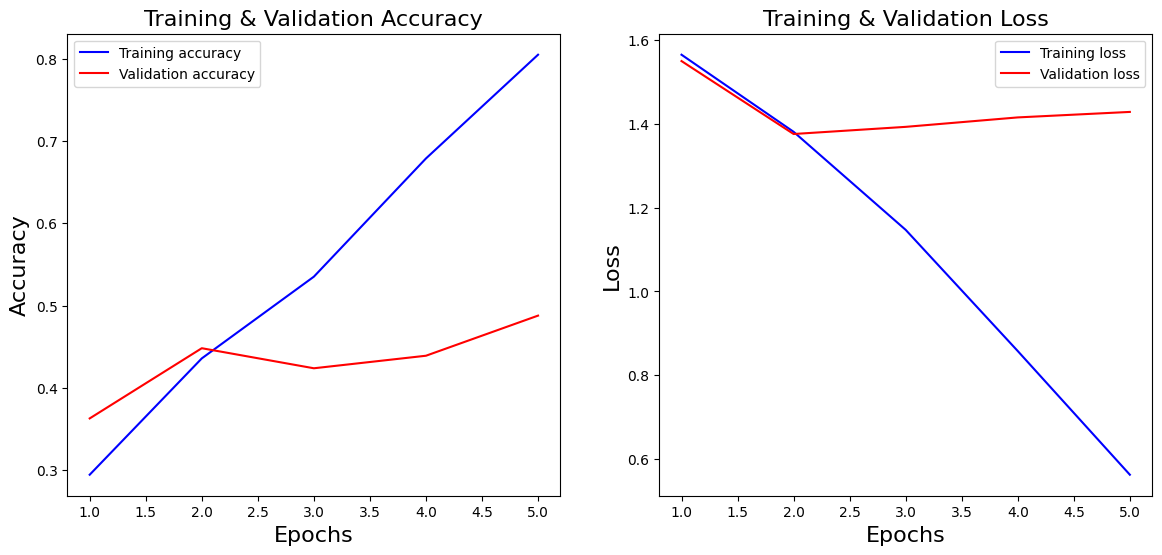

In [24]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Curva accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Curva loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Si nos fijamos en las curva del error, mientras que la curva del entrenamiento se aproxima a 0, el error en la validación aumenta. Esto significa que el modelo no ha aprendido a resolver el problema.
Por tanto, será necesario utilizar más datos y además, investigar en un modelo más complejo que sea capaz de resolver la tarea.

Idealmente, ambas curvas loss deberían tender a 0. Ese caso significa que el modelo es capaz de generalizar y resolve la tarea en el conjunto de validación.

### Evaluar el modelo



Aunque las curvas de aprendizaje nos dicen que deberíamos seguir investigando en mejorar el modelo, vamos a evaluarlo sobre el conjunto test. En primer lugar, vamos a obtener las métricas loss y  accuracy en dicho conjunto (que no ha sido utilizado en ninguna fase del entrenamiento).
En el modelo CNN con inicialización aleatoria, los resultados eran:
loss: 2.6302 - accuracy: 0.4050



In [25]:
X_test = df_test['text'].tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)


73/73 [==============================] - 0s 2ms/step - loss: 1.5233 - accuracy: 0.4594


Por tanto, podemos concluir que el uso de word embeddings ha mejorado los resultados (aunque todavía son muy bajos y sería necesario investigar con otra arquitectura e hiperparámetros).



Es posible obtener una evaluación más detallada con las métricas de precisión, recall y F1, para cada clase, gracias a la librería sklearn.

Antes vamos a recordar los resultados que obtenía el modelo CNN con inicialización aleatoria:

||precision|    recall|  f1-score|   support|
|--|--|--|--|--|
|ideological-inequality|0.47|0.62|0.54|333|
|stereotyping-dominance|0.36|0.24|0.29|215|
|sexual-violence|0.42|0.24|0.31|150|
|misogyny-non-sexual-violence|0.61|0.22|0.33|198|
|objectification|0.31|0.50|0.38|262|
|accuracy |--|--|0.41|1158|
|macro avg|0.44|0.36|0.37|1158|
|weighted avg|0.43|0.41|0.39|1158|

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
y_pred = np.argmax(model.predict(encoded_test), axis=1)
# print(y_pred[0:10])

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=LABELS))

37/37 [==============================] - 0s 3ms/step
accuracy: 0.459412780656304
                              precision    recall  f1-score   support

      stereotyping-dominance       0.55      0.70      0.61       333
misogyny-non-sexual-violence       0.43      0.14      0.22       215
             sexual-violence       0.36      0.29      0.32       150
             objectification       0.44      0.45      0.44       198
      ideological-inequality       0.40      0.51      0.45       262

                    accuracy                           0.46      1158
                   macro avg       0.44      0.42      0.41      1158
                weighted avg       0.45      0.46      0.44      1158



Podemos ver que aunque los resultados siguen siendo bastante bajos, la macro-F1 y la mayoría de las F1 se ven mejoradas con el uso de los word embeddings.


[[234  14   7  21  57]
 [ 55  31  27  55  47]
 [ 16   5  44  29  56]
 [ 29  17  26  89  37]
 [ 94   5  19  10 134]]


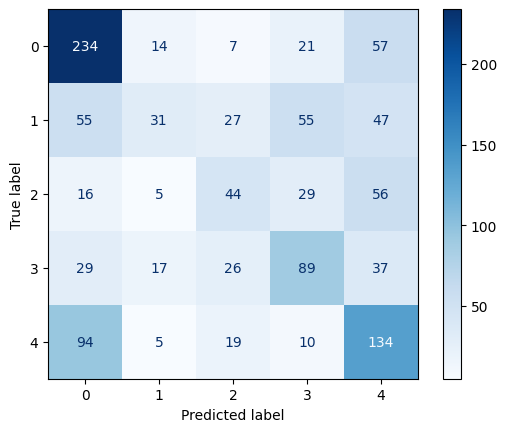

In [32]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)


Prueba con otras configuraciones de capas convolucionales y maxpooling.
Además, también es recomendable que pruebes con un número distinto de epochs y batch y que modifiques el proceso de EarlyStopping.